In [1]:
from google.colab import  drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
PATH="/content/drive/My Drive/SotoProject"
CKPATH=PATH+"/checkpoints"
# Partición 


In [4]:
IMG_WIDTH=256#1007
IMG_HEIGHT=256#768
#1007, 768
#----------
def resize(inimg, tgimg, heigth, width):
  inimg=tf.image.resize(inimg,[heigth,width])
  tgimg=tf.image.resize(inimg,[heigth,width])
  return inimg,tgimg
#----------------
def normalize(inimg,tgimg):
  inimg=(inimg/127.5)-1
  tgimg=(tgimg/127.5)-1
  return inimg,tgimg
#-----------------
@tf.function()
def random_jitter(inimg, tgimg):
  NIMG_HEIGHT=286#int(IMG_HEIGHT*286/256)
  NIMG_WIDTH=286#int(IMG_WIDTH*286/256)
  inimg= tf.image.resize(inimg, [NIMG_HEIGHT, NIMG_WIDTH])
  tgimg= tf.image.resize(tgimg, [NIMG_HEIGHT, NIMG_WIDTH])
  stacked_image=tf.stack([inimg,tgimg],axis=0)
  cropped_image=tf.image.random_crop(stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,3])

  inimg, tgimg=cropped_image[0],cropped_image[1]
  if tf.random.uniform(())>0.5:
    inimg=tf.image.random_flip_left_right(inimg)
    tgimg=tf.image.random_flip_left_right(tgimg)
  return inimg,tgimg

#---------------------------
def load_image(image_file, augment=True):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  if augment:
    input_image, real_image=random_jitter(input_image,real_image)

  input_image, real_image=normalize(input_image, real_image)
  return input_image, real_image

#-------------
def load_train_image(filename):
  return load_image(filename)
def load_test_image(filename):
  return load_image(filename,True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


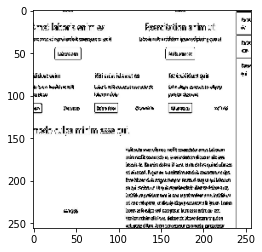

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


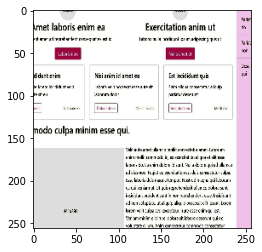

In [5]:
images=load_train_image(PATH+"/train/3.jpg")
plt.imshow(images[0])
plt.show()
plt.imshow(images[1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


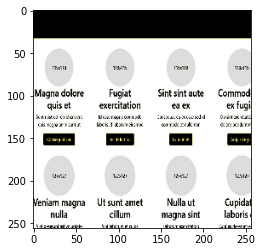

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


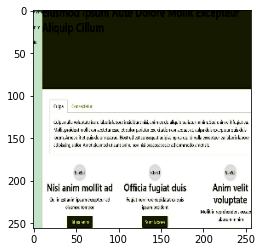

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


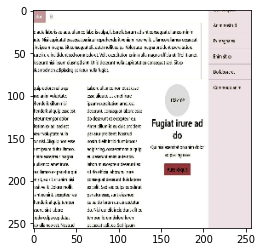

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


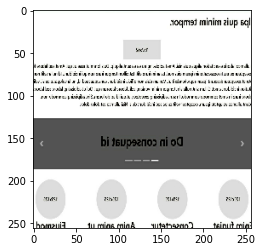

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


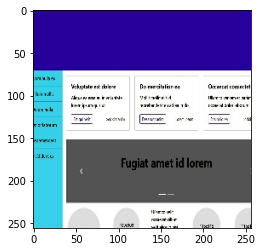

In [6]:
BATCH_SIZE=1
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.jpg')
train_dataset = train_dataset.map(load_train_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

for inimg,tgimg in train_dataset.take(5):
  plt.imshow(tgimg[0,...])
  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


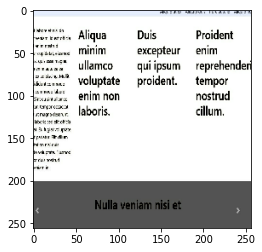

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


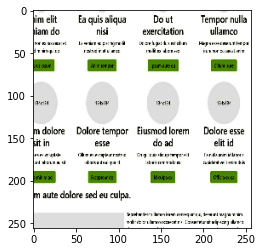

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


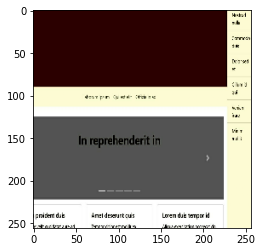

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


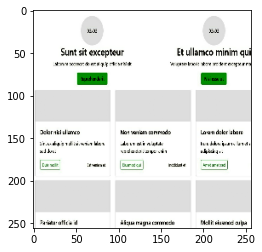

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


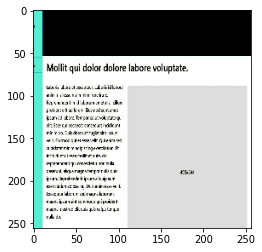

In [7]:
test_dataset = tf.data.Dataset.list_files(PATH+'/test/*.jpg')
test_dataset = test_dataset.map(load_test_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
for inimg,tgimg in test_dataset.take(5):
  plt.imshow(tgimg[0,...])
  plt.show()

In [8]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  result=Sequential()
  initializer=tf.random_normal_initializer(0,0.02)

  result.add(Conv2D(
      filters,
      kernel_size=4,
      strides=2,
      padding="same",
      kernel_initializer=initializer,
      use_bias=not apply_batchnorm
  ))

  if apply_batchnorm:
    result.add(BatchNormalization())
  result.add(LeakyReLU())
  return result
downsample(64)

In [9]:
def upsample(filters, apply_dropout=True):
  result=Sequential()
  initializer=tf.random_normal_initializer(0,0.02)

  result.add(Conv2DTranspose(
      filters,
      kernel_size=4,
      strides=2,
      padding="same",
      kernel_initializer=initializer,
      use_bias=False
  ))
  result.add(BatchNormalization())

  if apply_dropout:
    result.add(Dropout(0.5))
  result.add(ReLU())
  return result
upsample(64)

(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 256)
(None, None, None, 512)
(None, None, None, 512)
(None, None, None, 512)
(None, None, None, 512)
(None, None, None, 512)
(1, 256, 256, 3) (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


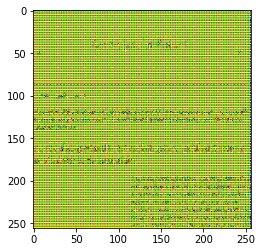

In [10]:
def Generator():
  #1007, 768
  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False), # (bs, 504, 384, 64)
    downsample(128), # (bs, 252, 192, 128)
    downsample(256), # (bs, 126, 96, 256)
    downsample(512), # (bs, 16, 16, 512)
    downsample(512), # (bs, 63, 48, 512)
    downsample(512), # (bs, 32, 24, 512)
    downsample(512), # (bs, 8, 6, 512)
    downsample(512), # (bs, 4, 3, 512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512), # (bs, 16, 16, 1024)
    upsample(256), # (bs, 32, 32, 512)
    upsample(128), # (bs, 64, 64, 256)
    upsample(64), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(filters=3, 
                         kernel_size= 4,
                         strides=2,
                         padding='same',
                         kernel_initializer=initializer,
                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  s = []
  concat=Concatenate()
  for down in down_stack:    
    x = down(x)
    print(x.shape)
    s.append(x)

  s = reversed(s[:-1])

  # Upsampling and establishing the skip connections
  for up, sk in zip(up_stack, s):
    
    x = up(x)    
    x = concat([x, sk])

  last = last(x)

  return tf.keras.Model(inputs=inputs, outputs=last)

generator=Generator()
for inimg, tgimg in train_dataset.take(1):
  print(inimg.shape,tgimg.shape)
image=inimg
gen_output=generator((image+1)*255, training=False)
plt.imshow(gen_output[0,...])

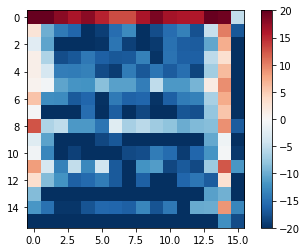

In [11]:
def Discriminator():
  ini=Input(shape=[None,None,3], name="input_img")
  gen=Input(shape=[None,None,3], name="gener_img")

  con=concatenate([ini,gen])

  initializer=tf.random_normal_initializer(0,0.02)
  down1=downsample(64, apply_batchnorm=False)(con)
  down2=downsample(128)(down1)
  down3=downsample(256)(down2)
  down4=downsample(512)(down3)

  last=Conv2D(filters=1,
              kernel_size=4,
              strides=1,
              kernel_initializer=initializer,
              padding="same")(down4)
            
  return Model(inputs=[ini,gen],outputs=last)
discriminator=Discriminator()   
disc_out=discriminator([((image+1)*255),gen_output], training=False)
plt.imshow(disc_out[0,...,-1],vmin=-20,vmax=20,cmap='RdBu_r')
plt.colorbar()          

In [12]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [14]:
LAMBDA=100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + (LAMBDA*l1_loss)

  return total_gen_loss

In [15]:
import os
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(CKPATH))

In [16]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH+"/output/"+save_filename+".jpg", prediction[0,...])

  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

In [17]:
@tf.function()
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    output_image=generator(input_image, training=True)
    output_gen_discr=discriminator([output_image,input_image], training=True)
    output_trg_discr=discriminator([target, input_image],training=True)
    discr_loss=discriminator_loss(output_trg_discr, output_gen_discr)
    gen_loss=generator_loss(output_gen_discr,output_image, target)

    generator_grads=gen_tape.gradient(gen_loss,generator.trainable_variables)
    discriminator_grads=discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))



In [18]:
from IPython.display import  clear_output

def train(dataset,epochs):
  for epoch in range(epochs):
    imgi=0
    for input_image, target in dataset:
      print('epoch'+str(epoch)+'-train:'+ str(imgi)+'/'+str(len(dataset)-1))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)
    for inp, tar in test_dataset.take(5):
      generate_images(generator,inp, tar, str(imgi)+"_"+str(epoch),display_imgs=True)
    
    if(epoch+1)%2==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

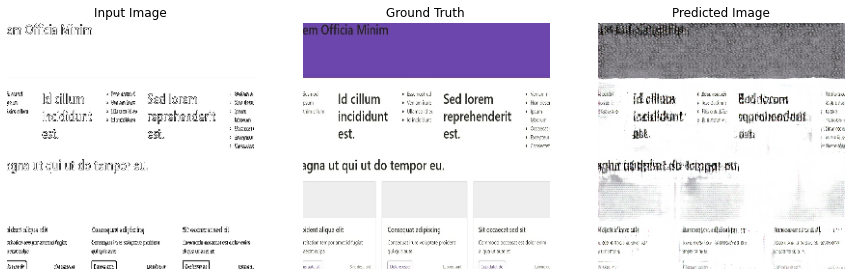

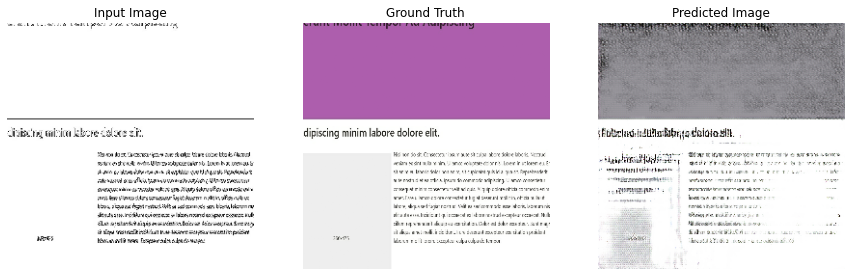

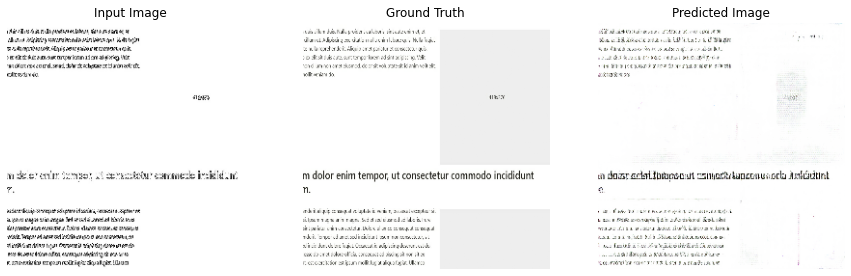

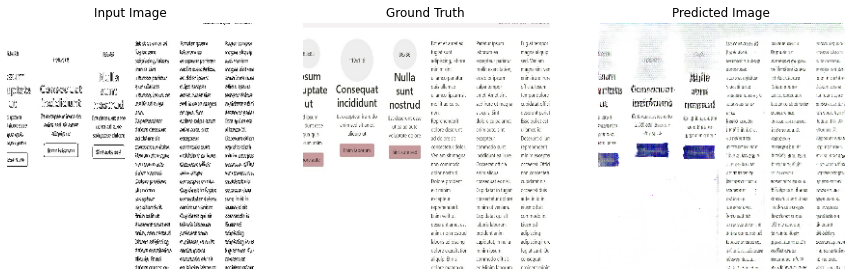

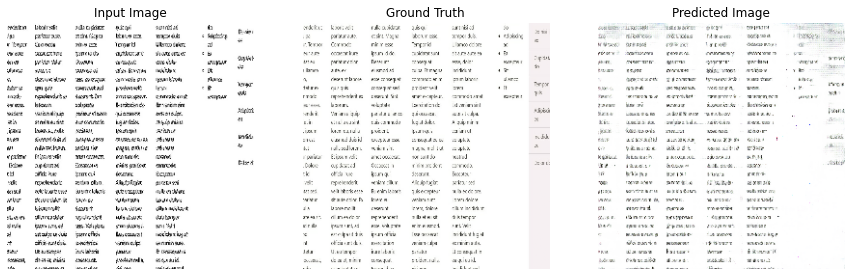

In [19]:
train(train_dataset,100)